# Week 4 - Partial Least Squares Regression

We will reimplement and then explore some of the properties of [Cosgrove et al](http://pubs.rsc.org/en/Content/ArticleLanding/2010/MB/b926287c).

In [4]:
import scipy as sp, numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt

data = sp.io.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principal components do you need for each to explain 90% of the Y variance? Discuss your findings.

Hint: Be sure you are normalizing each dataset as needed for the analysis.

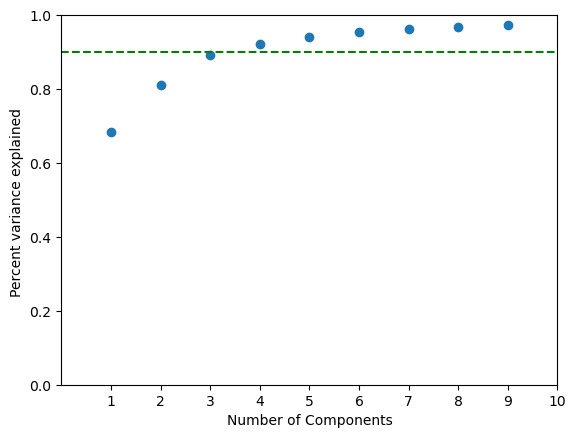

In [10]:
# Create a list of components to evaluate
num_components = np.arange(1, 10, 1)
r2_scores = []

# Iterate over the components and fit a PLSR model with each component
for component in num_components:
    pls = PLSRegression(n_components=component)
    pls.fit(X, Y[:, -1])
    r2_scores.append(pls.score(X, Y[:, -1]))

# Plot the percent variance explained for each component
plt.scatter(num_components, r2_scores)
plt.ylabel('Percent variance explained ')
plt.xlabel('Number of Components')
plt.plot([0, 100], [0.9, 0.9], '--g')
plt.ylim([0, 1])
plt.xlim([0, 10])
plt.xticks(np.arange(1, 11, 1));

1. The study shows that 4 components are required to explain 90% of the variance in Y
2. The first components explain the largest portions of variance
3. Each subsequent component explains less of the remaining variance than the previous one
4. The variance explained approaches 1 asymptotically.

#### (2) How would you expect the percent of X variance explained to compare between PLSR and PCA? Why?

In summary, it is expected that PCA would have a higher percentage of variance explained in X compared to PLSR. This is because PCA selects components that reduce variance in X, whereas PLSR selects components that minimize the covariance between X and Y. Therefore, PCA is designed to specifically explain the variance in X, while PLSR is not.





#### (3) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

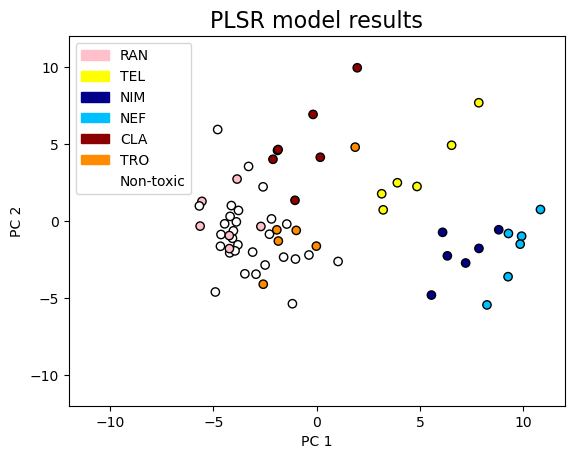

In [12]:
import matplotlib.patches as mpatches

# Apply PLS regression using 4 components
reg = PLSRegression(n_components=4)
reg.fit(X, Y[:, -1])
results = reg.x_scores_
# Retain only the first two results
components = results[:, :2]

# Plot the results
fig, ax = plt.subplots()
ax.set_xlim([-12, 12])
ax.set_ylim([-12, 12])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('PLSR model results', fontsize=16)

# Define colors for different drugs
drug_colors = {
    'RAN': 'pink',
    'TEL': 'yellow',
    'NIM': 'darkblue',
    'NEF': 'deepskyblue',
    'CLA': 'darkred',
    'TRO': 'darkorange',
    'Non-toxic': 'white'
}

# Assign colors to each data point
colors = []
for i in range(len(results)):
    drug = np.argwhere(drugs[i] == 1)
    drug = drugList[drug][0][0]
    
    color = 'white'
    if drug in drug_colors.keys():
        color = drug_colors[drug]
    
    colors.append(color)
    
# Plot the legend
drug_types = list(drug_colors.keys())
legend_elements = [mpatches.Patch(color=drug_colors[i], label=i) for i in drug_types]

# Plot the scatter plot
ax.scatter(components[:, 0], components[:, 1], color=colors,
           edgecolors='k')

ax.legend(handles=legend_elements)
plt.show()


#### (4) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

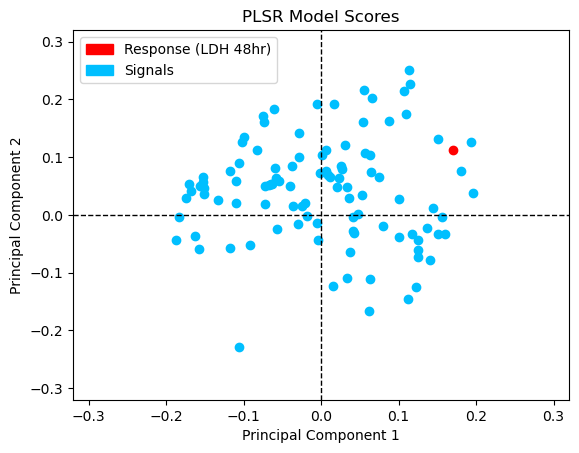

In [31]:
weights = pls.x_weights_
response_weights = pls.y_weights_

principal_components = weights[:, :2]

fig, ax = plt.subplots()
ax.set_xlim([-0.32, 0.32])
ax.set_ylim([-0.32, 0.32])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PLSR Model Scores')

patches = [mpatches.Patch(color='red', label='Response (LDH 48hr)'),
mpatches.Patch(color='deepskyblue', label='Signals')]
ax.legend(handles=patches)

ax.axhline(y=0, color='k', linestyle='--', lw=1)
ax.axvline(x=0, color='k', linestyle='--', lw=1)
ax.scatter(principal_components[:, 0], principal_components[:, 1], color='deepskyblue')
ax.scatter(response_weights[0, 0], response_weights[0, 1], color='red')
plt.show()

The plot illustrates the relationship between the response (LDH 48hr) and the signals through the first two principal components. The red dot represents the response and the gray dots stand for the signals. The response has a positive relationship with both principal components, but a stronger association with PC 1 compared to PC 2. This means that increasing elements that are positively linked to both PC 1 and PC 2, or decreasing elements that are negatively associated with both, will result in an increased response. Additionally, a higher positive association with PC 1 compared to PC 2 will also result in an increased response. Most of the signals show a positive association with one of the two components. There are only a few signals that are negatively associated with both components, meaning that few signals are opposing the response along both components.

#### (5) Add the variance of the loadings to your loadings plot (this can be shown as error bars). How does the variance of component one compare to that of component two? Would you expect a trend in the general variance versus component number?

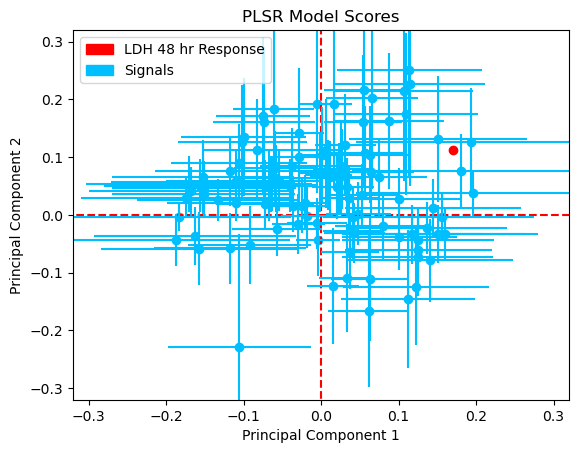

In [30]:
from sklearn.utils import resample
import pandas as pd

components = weights[:, :2]

plt.figure()
plt.ylim([-.32, .32])
plt.xlim([-.32, .32])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PLSR Model Scores')

legend_labels = [mpatches.Patch(color='red', label='LDH 48 hr Response'),
                 mpatches.Patch(color='deepskyblue', label='Signals')]
plt.legend(handles=legend_labels)

plt.plot([-10, 10], [0, 0], '--r')
plt.plot([0, 0], [-10, 10], '--r')
plt.scatter(components[:, 0], components[:, 1], color='deepskyblue')
plt.scatter(response_weights[0, 0], response_weights[0, 1], color='red')

num_simulations = 1000
first_var_data = pd.DataFrame(index=range(num_simulations), columns=range(102))
second_var_data = pd.DataFrame(index=range(num_simulations), columns=range(102))
resampled_loadings = np.empty((num_simulations, components.shape[0], 2))

for i in range(num_simulations):
    bootstrapped_x, bootstrapped_y = resample(X, Y[:, -1])
    plsr = PLSRegression(n_components=2)
    plsr.fit(bootstrapped_x, bootstrapped_y)
    resampled_loadings[i, :, :] = plsr.x_weights_[:, :2]
    
variance = np.std(resampled_loadings, axis=0)
plt.errorbar(components[:, 0], components[:, 1], xerr=variance[:, 0], yerr=variance[:, 1], linestyle='', color='deepskyblue')
plt.show()


In summary, as the component number increases, there is usually a higher chance for variations in the model, due to the fact that the higher components are derived from the residuals of lower components. This high level of variance suggests that a replicated dataset could potentially produce significantly different results.





#### (6) Recreate a 4-principal component model using PLSR with just the final 4 phosphoprotein model. Plot predicted v. observed LDH for this model. Report the model fitness ($R^2$). Define here how you are calculating $R^2$.

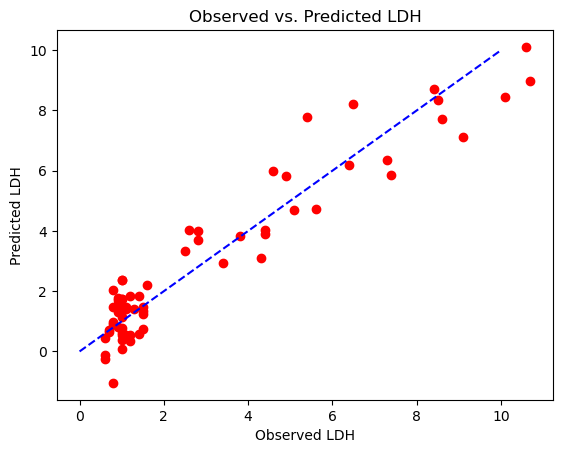

Model Fitness (R-squared): 0.9031360902736856


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.cross_decomposition import PLSRegression

final_4 = ['p-MEK1', 'p-ERK1/2', 'p-Akt', 'p-p70 S6K', 'p-p38', 'p-HSP27']

# Keep only the relevant phosphoproteins
to_keep = [i for i, phospho in enumerate(phosphoproteins) if any([final in phospho for final in final_4])]
trimmed_X = X[:, to_keep]

# Fit a PLSR model
model = PLSRegression(n_components=4)
model.fit(trimmed_X, Y[:, -1])

# Predict and evaluate the model
predicted = model.predict(trimmed_X)
score = r2_score(Y[:, -1], predicted)

# Plot the results
plt.figure()
plt.ylabel('Predicted LDH')
plt.xlabel('Observed LDH')
plt.title('Observed vs. Predicted LDH')
plt.plot([0, 10], [0, 10], '--b')
plt.scatter(Y[:, -1], predicted, color='r')
plt.show()

print(f'Model Fitness (R-squared): {score}')


The R-squared value is calculated by using the X and Y matrices to fit a model. This model is then used to predict Y from X. The prediction is compared to the actual values of Y using the r2score function from sklearn to find the R-squared score.





#### (7) Cosgrove *et al* discusses their method for model validation using leave-one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

In [38]:
prediction = cross_val_predict(model, trimmed_X, Y[:, -1], cv=LeaveOneOut())
print(f'Model Accuracy (R-squared): {r2_score(Y[:, -1], prediction)}')

Model Accuracy (R-squared): 0.8418832347463815


The R-squared value calculated in this code is lower than the previous result, which shows that the model's accuracy is lower than previously estimated. This highlights the significance of cross-validation, as the previous method of testing model accuracy included the testing data in the model training, potentially leading to an overestimation of accuracy. By using cross-validation, the testing and training data are separated into different folds to prevent the model from prematurely learning the testing data.





#### (8) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

In [39]:
modeled_data = [i % 6 + 1 for i in range(66)]

validation = LeaveOneGroupOut().split(trimmed_X, Y[:, -1], modeled_data)
predicted_outcome = cross_val_predict(pls, trimmed_X, Y[:, -1], cv=validation)

print(f'Model Performance (R-squared): {r2_score(Y[:, -1], predicted_outcome)}')

Model Performance (R-squared): 0.7535410393607305
